In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from skimage import exposure
from skimage import filters
from scipy import ndimage

from os import path
import pims


In [2]:
folder_path = path.join('I:','alex_ultasound','monday_22_02_2021')

bench_mark_file_list = [path.join('ss316_bench','ss316_bench_3_m.cine')]

ultrasound_file_list = [path.join('18v_ss316','ss316_us_1.cine')]

bench_mark = [pims.open(path.join(folder_path,f_name)) for f_name in bench_mark_file_list]
ultrasound = [pims.open(path.join(folder_path,f_name)) for f_name in ultrasound_file_list]

In [3]:
bench_s = [np.concatenate((np.arange(218,7020+1), np.arange(11164,20498 + 1)), axis = 0)[:13001]]
ultrasound_s= [np.concatenate((np.arange(5299,9979+1), np.arange(12683,21939 + 1)), axis = 0)[:13001]]

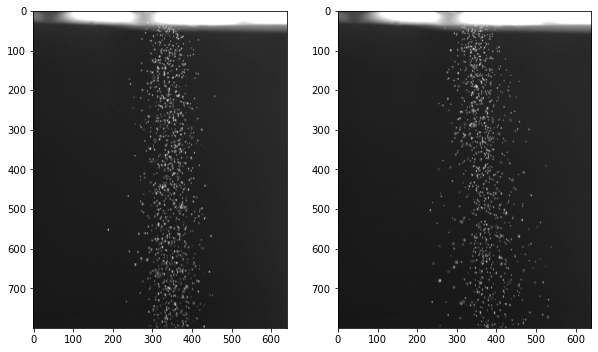

In [4]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(bench_mark[0][0], cmap = 'gray')
axs[1].imshow(ultrasound[0][0], cmap = 'gray')
plt.show()

## Set cropping and sampling

In [5]:
@pims.pipeline
def crop_top(image):
    return image[80:,:]

In [6]:
test_bench = crop_top(bench_mark[0])
test_ultrasound = crop_top(ultrasound[0])

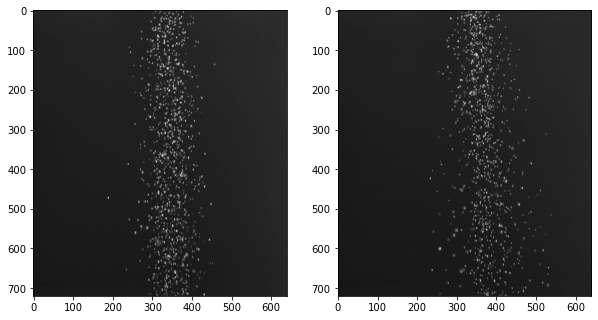

In [7]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(test_bench[0], cmap = 'gray')
axs[1].imshow(test_ultrasound[0], cmap = 'gray')
plt.show()

In [8]:
from skimage import restoration
from skimage import morphology

@pims.pipeline
def denoise_nl(image):
    sig = restoration.estimate_sigma(image,average_sigmas = True)
    return restoration.denoise_nl_means(image, sigma = sig)

@pims.pipeline
def denoise_median(image):
    selem = morphology.disk(3)
    return filters.median(image, selem)

In [9]:
@pims.pipeline
def binarise(image):
    thresh = filters.threshold_otsu(image)
    return (thresh <= image).astype(int)

@pims.pipeline
def binarise_half_way(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return ((min_val+(max_val-min_val)*0.20) <= image).astype(int)

binary_vid_bench = binarise_half_way(test_bench)
binary_vid_ultrasound = binarise_half_way(test_ultrasound)

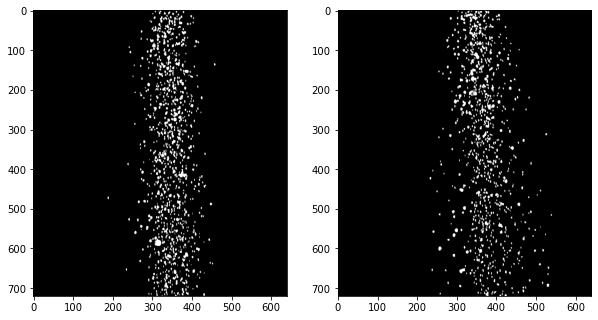

In [10]:
fig, axs = plt.subplots( 1, 2, figsize = (10,10))
axs[0].imshow(binary_vid_bench[0],cmap = 'gray')
axs[1].imshow(binary_vid_ultrasound[0],cmap = 'gray')
plt.show()

In [11]:
from tqdm import tqdm

def bulk_process(ls_im, ls_sample):
    data = []
    count = 0
    pbar = tqdm(len(ls_im))
    for vid, s_frame in zip(ls_im, ls_sample):
        cropped_vid = crop_top(vid)
        binary_vid = binarise_half_way(cropped_vid)
        data.append(np.sum(binary_vid[s_frame], axis = 0))
        count+=1
        pbar.update(1)
    return np.stack(data, axis = 0)

In [12]:
bench_data = bulk_process(bench_mark, bench_s)

1it [06:43, 403.04s/it]

In [13]:
ultrasound_data = bulk_process(ultrasound, ultrasound_s)


1it [07:49, 469.63s/it]

1it [05:28, 328.88s/it]

In [14]:
from scipy.io import savemat

savemat("./data/ss316.mat", {'bench' : bench_data, 'ultrasound': ultrasound_data})